In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
%matplotlib inline

In [2]:
np.random.seed(123)
solvers.options['show_progress'] = False

In [3]:
# number of assets is 4
n_assets = 4
# number of observations is 1000
n_obs = 1000
return_vec = np.random.randn(n_assets, n_obs)

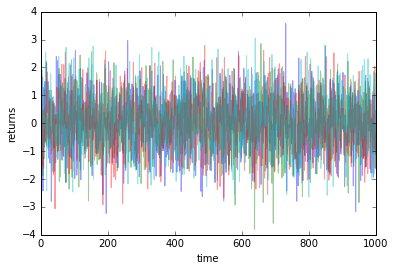

In [4]:
# lets see this assets
plt.plot(return_vec.T, alpha=.4)
plt.xlabel('time')
plt.ylabel('returns')

In [7]:
def rand_weights(n_assets):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n_assets)
    return k/sum(k)

In [8]:
print(rand_weights(n_assets))

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]


In [9]:
print(rand_weights(n_assets))

[ 0.27638339  0.03006307  0.47850085  0.21505269]


In [14]:
np.asmatrix(np.mean(return_vec, axis=1))

matrix([[-0.03956414,  0.00838917,  0.01035309,  0.06647869]])

In [15]:
def random_portfolio(returns):
    '''
    Returns the means and std of returns for a random portfolio
    '''
    # mean return of each asset
    p = np.asmatrix(np.mean(returns, axis=1))
    # weights 
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w*p.T
    sigma = np.sqrt(w*C*w.T)
    
    # this recursions reduces the outliers and keep the plot pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [17]:
n_portfolios = 500
means, std = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])

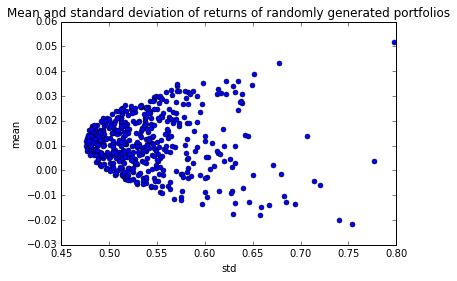

In [19]:
plt.plot(std, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [24]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [25]:
weights, returns, risks = optimal_portfolio(return_vec)

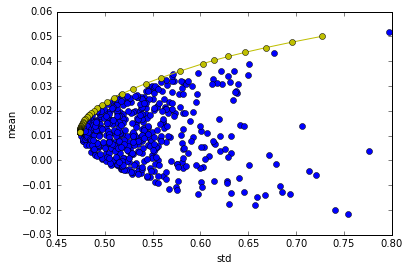

In [27]:
plt.plot(std, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [29]:
print(weights)

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]
